NN All Collisions

Creates masks and associated df of neuronal network where there is no collision check/event: all neuron dendrites can grow through/over eachother with no alteration of growth behavior. Produces maximum complexity. 

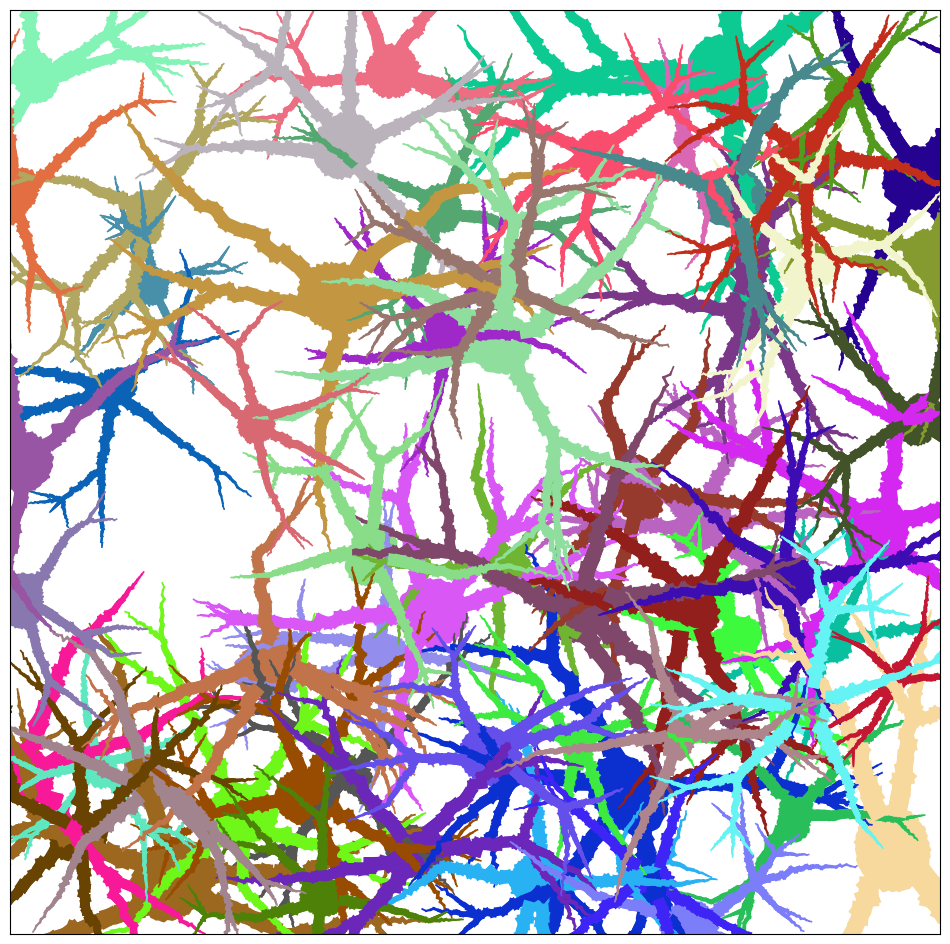

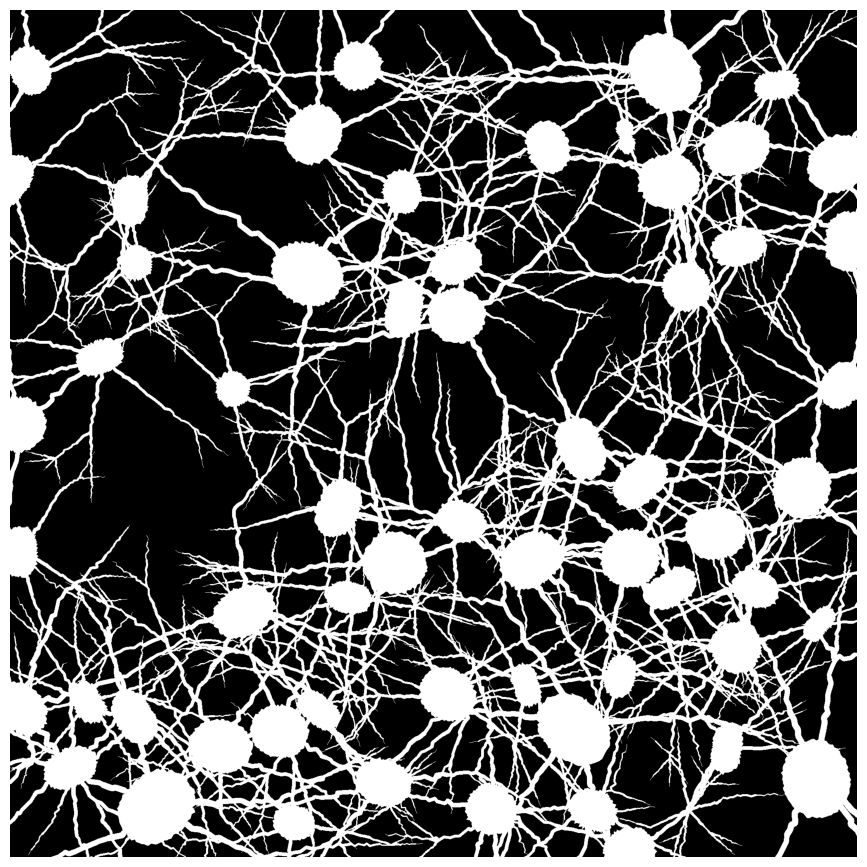

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import os
import tifffile as tiff
import pickle

class Soma:
    def __init__(self, position, mean_radius, std_radius):
        self.position = position
        self.radius = max(np.random.normal(mean_radius, std_radius), 0)
        self.x_soma, self.y_soma = self._generate_soma()

    def _generate_soma(self):
        theta = np.linspace(0, 2 * np.pi, 100)
        sine_variation = np.random.uniform(0, 15) * np.sin(2 * theta)
        gaussian_variation = np.random.normal(0, 2, len(theta))
        ellipse_ratio = np.random.uniform(0.8, 1.2)
        elongation_angle = np.random.uniform(0, 2 * np.pi)

        x_soma = (self.radius + gaussian_variation + sine_variation) * (
            np.cos(theta) * np.cos(elongation_angle) - np.sin(theta) * np.sin(elongation_angle) * ellipse_ratio
        ) + self.position[0]
        y_soma = (self.radius + gaussian_variation + sine_variation) * (
            np.sin(theta) * np.cos(elongation_angle) + np.cos(theta) * np.sin(elongation_angle) * ellipse_ratio
        ) + self.position[1]

        return x_soma, y_soma

    def draw(self, color):
        plt.fill(self.x_soma, self.y_soma, color=color)

    def create_binary_mask(self, size=(2048, 2048)):
        mask = np.zeros(size, dtype=np.uint8)
        coordinates = np.array([self.x_soma, self.y_soma]).T.astype(np.int32)
        cv2.fillPoly(mask, [coordinates], 1)
        return mask

class Dendrite:
    def __init__(
        self,
        soma,
        depth,
        D,
        branch_angle,
        mean_branches,
        weave_type=None,
        randomness=0.0,
        curviness=None,
        curviness_magnitude=1.0,
        n_primary_dendrites=4,
    ):
        self.soma = soma
        self.depth = depth
        self.D = D
        self.branch_angle = branch_angle
        self.mean_branches = mean_branches
        self.weave_type = weave_type
        self.randomness = randomness
        self.curviness = curviness
        self.curviness_magnitude = curviness_magnitude
        self.n_primary_dendrites = n_primary_dendrites
        self.dendrite_list = []

        self.total_length = self._scale_total_length()
        self.initial_thickness = self._scale_initial_thickness()
        self.branch_lengths = self._generate_branch_lengths()

    def _scale_total_length(self):
        base_length = 40
        length_variation_factor = 5
        total_length = base_length + (self.soma.radius * length_variation_factor) * np.random.uniform(0.8, 1.2)
        return max(total_length, 0)

    def _generate_branch_lengths(self):
        r = self.mean_branches ** (-1 / self.D)
        branch_lengths = np.zeros(self.depth)
        normalization_factor = self.total_length / sum(r ** i for i in range(self.depth))

        for i in range(self.depth):
            branch_lengths[i] = normalization_factor * r ** i

        return branch_lengths

    def _generate_dendrite_start_points(self):
        start_points = []
        num_soma_points = len(self.soma.x_soma)
        base_indices = np.linspace(0, num_soma_points - 1, self.n_primary_dendrites, endpoint=False).astype(int)

        random_offsets = np.random.randint(
            -num_soma_points // (100 // self.n_primary_dendrites // 1.5),
            (100 // self.n_primary_dendrites // 1.5) + 1,
            size=self.n_primary_dendrites,
        )
        random_indices = (base_indices + random_offsets) % num_soma_points

        for index in random_indices:
            start_points.append((self.soma.x_soma[index], self.soma.y_soma[index]))

        return start_points

    def _scale_initial_thickness(self):
        base_thickness = 1
        thickness_factor = 0.02
        initial_thickness = base_thickness + thickness_factor * (self.soma.radius + self.total_length)
        return max(initial_thickness, 1)

    def _calculate_thickness(self, distance_from_start, segment_length):
        # Calculate proportions
        proportion_start = 1 - (distance_from_start / self.total_length)
        proportion_end = 1 - ((distance_from_start + segment_length) / self.total_length)

        # Ensure proportions are within [0, 1]
        proportion_start = np.clip(proportion_start, 0, 1)
        proportion_end = np.clip(proportion_end, 0, 1)

        # Calculate thicknesses
        thickness_at_start = self.initial_thickness * (proportion_start) ** (1 / self.D)
        thickness_at_end = self.initial_thickness * (proportion_end) ** (1 / self.D)

        # Ensure thicknesses are at least 1
        thickness_at_start = max(thickness_at_start, 1)
        thickness_at_end = max(thickness_at_end, 1)

        return thickness_at_start, thickness_at_end

    def intra_branch_weave(self, x1, y1, x2, y2, length):
        num_points = int(self.curviness_magnitude * 10)
        xs = np.linspace(x1, x2, num_points)
        ys = np.linspace(y1, y2, num_points)

        if self.curviness == 'Gauss':
            perturb_xs = xs + (length // 50) * np.random.normal(0, 1, num_points)
            perturb_ys = ys + (length // 50) * np.random.normal(0, 1, num_points)
        elif self.curviness == 'Uniform':
            perturb_xs = xs + (length // 50) * np.random.uniform(-1, 1, num_points)
            perturb_ys = ys + (length // 50) * np.random.uniform(-1, 1, num_points)
        else:
            perturb_xs = xs
            perturb_ys = ys

        perturb_xs[0], perturb_ys[0] = x1, y1
        perturb_xs[-1], perturb_ys[-1] = x2, y2

        return perturb_xs, perturb_ys

    def _grow_branch(self, x, y, angle, remaining_depth):
        if remaining_depth == 0:
            return None, []

        branch_length = self.branch_lengths[self.depth - remaining_depth]
        # Calculate the cumulative path length from the soma up to the current depth
        sum_length = sum(self.branch_lengths[:self.depth - remaining_depth])

        thickness_start, thickness_end = self._calculate_thickness(sum_length, branch_length)

        if self.weave_type == 'Gauss':
            branch_length *= 1 + np.random.normal(0, self.randomness)
            angle += np.random.normal(0, self.randomness)
        elif self.weave_type == 'Uniform':
            branch_length *= 1 + np.random.uniform(-self.randomness, self.randomness)
            angle += np.random.uniform(-self.randomness, self.randomness)

        end_x = x + branch_length * np.cos(angle)
        end_y = y + branch_length * np.sin(angle)

        weave_x, weave_y = self.intra_branch_weave(x, y, end_x, end_y, branch_length)

        branch_data = {
            'points': np.array([weave_x, weave_y]),
            'length': branch_length,
            'depth': self.depth - remaining_depth,
            'thickness_start': thickness_start,
            'thickness_end': thickness_end
        }

        num_branches = int(np.clip(np.round(np.random.normal(self.mean_branches, 1)), 1, None))
        new_branches = []

        for i in range(num_branches):
            new_angle = angle + self.branch_angle * (i - (num_branches - 1) / 2)
            if self.weave_type == 'Gauss':
                new_angle += np.random.normal(0, self.randomness)
            elif self.weave_type == 'Uniform':
                new_angle += np.random.uniform(-self.randomness, self.randomness)

            new_branches.append(((end_x, end_y), new_angle))

        return branch_data, new_branches

    def draw(self, color):
        for branch in self.dendrite_list:
            points = branch['points']
            thickness_start = branch['thickness_start']
            thickness_end = branch['thickness_end']
            thicknesses = np.linspace(thickness_start, thickness_end, len(points[0]))

            for i in range(len(points[0]) - 1):
                plt.plot(points[0][i:i + 2], points[1][i:i + 2], color=color, linewidth=thicknesses[i])

    def create_dendrite_mask(self, size=(2048, 2048)):
        mask = np.zeros(size, dtype=np.uint8)

        for branch in self.dendrite_list:
            points = branch['points']
            thickness_start = branch['thickness_start']
            thickness_end = branch['thickness_end']
            thicknesses = np.linspace(thickness_start, thickness_end, len(points[0]))
            # Round thicknesses and ensure they are at least 1
            thicknesses = np.clip(np.round(thicknesses), 1, None).astype(int)
            coordinates = np.column_stack((points[0], points[1])).astype(np.int32)
            for i in range(len(coordinates) - 1):
                cv2.line(mask, tuple(coordinates[i]), tuple(coordinates[i + 1]), 1, thickness=thicknesses[i])

        return mask

class Neuron:
    def __init__(
        self,
        position,
        depth,
        mean_soma_radius,
        std_soma_radius,
        D,
        branch_angle,
        mean_branches,
        weave_type=None,
        randomness=0.0,
        curviness=None,
        curviness_magnitude=1.0,
        n_primary_dendrites=4,
        network=None,
        neuron_id=None,
    ):
        self.network = network
        self.position = position
        self.soma = Soma(position, mean_soma_radius, std_soma_radius)
        self.soma_mask = self.soma.create_binary_mask(size=(network.height, network.width))
        self.dendrite = Dendrite(
            self.soma,
            depth,
            D,
            branch_angle,
            mean_branches,
            weave_type,
            randomness,
            curviness,
            curviness_magnitude,
            n_primary_dendrites,
        )
        self.dendrite_mask = np.zeros((network.height, network.width), dtype=np.uint8)
        self.neuron_mask = None
        self.neuron_id = neuron_id
        self.current_depth = 0
        self.start_points = None
        self.branch_ends = []
        self.is_growing = True  # Flag to indicate if the neuron is still growing

    def generate_start_points(self):
        self.start_points = self.dendrite._generate_dendrite_start_points()
        self.branch_ends = [
            (point, np.arctan2(point[1] - self.position[1], point[0] - self.position[0])) for point in self.start_points
        ]

    def prepare_next_layer(self):
        """
        Prepare the proposed branches for the next layer without updating the dendrite mask.
        """
        if self.current_depth >= self.dendrite.depth or not self.branch_ends:
            self.is_growing = False
            return []

        proposed_branches = []

        for start_point, angle in self.branch_ends:
            branch_data, new_branches = self.dendrite._grow_branch(
                start_point[0], start_point[1], angle, self.dendrite.depth - self.current_depth
            )

            if branch_data is not None:
                proposed_branches.append({
                    'branch_data': branch_data,
                    'start_point': start_point,
                    'new_branches': new_branches  # Include new branch ends
                })

        return proposed_branches

    def add_branches(self, accepted_branches):
        """
        Add the accepted branches to the dendrite list, update the dendrite mask, and update branch ends.
        """
        new_branch_ends = []

        for branch_info in accepted_branches:
            branch_data = branch_info['branch_data']
            start_point = branch_info['start_point']
            points = branch_data['points']
            new_branches = branch_info['new_branches']

            # Update dendrite list
            self.dendrite.dendrite_list.append(branch_data)

            # Update dendrite mask
            coordinates = np.column_stack((points[0], points[1])).astype(np.int32)
            thickness_start = branch_data['thickness_start']
            thickness_end = branch_data['thickness_end']
            thicknesses = np.linspace(thickness_start, thickness_end, len(coordinates))
            thicknesses = np.clip(np.round(thicknesses), 1, None).astype(int)
            for i in range(len(coordinates) - 1):
                cv2.line(
                    self.dendrite_mask,
                    tuple(coordinates[i]),
                    tuple(coordinates[i + 1]),
                    1,
                    thickness=thicknesses[i],
                )

            # Update branch ends with new branches from accepted branches
            new_branch_ends.extend(new_branches)

        # Update self.branch_ends for the next layer
        self.branch_ends = new_branch_ends

    def draw(self, color):
        self.soma.draw(color)
        self.dendrite.draw(color)

    def generate_binary_mask(self):
        soma_mask = self.soma_mask
        dendrite_mask = self.dendrite_mask
        self.neuron_mask = np.logical_or(soma_mask, dendrite_mask).astype(np.uint8)
        return self.neuron_mask

class Network:
    def __init__(self, width, height, num_neurons, neuron_params, network_id):
        self.width = width
        self.height = height
        self.num_neurons = num_neurons
        self.neuron_params = neuron_params
        self.neurons = []
        self.network_mask = np.zeros((self.height, self.width), dtype=np.uint8)
        self.somas_mask = np.zeros((self.height, self.width), dtype=np.uint8)
        self.network_dendrites_mask = np.zeros((self.height, self.width), dtype=np.uint8)
        self.network_id = network_id

    def _seed_neurons(self):
        """
        Seeds neurons in the network, ensuring that no two somas overlap.
        """
        for neuron_index in range(self.num_neurons):
            max_attempts = 100  # Limit the number of attempts to avoid infinite loops
            attempts = 0

            while attempts < max_attempts:
                # Generate a random position for the neuron
                position = (np.random.uniform(0, self.width), np.random.uniform(0, self.height))
                neuron_id = f"{self.network_id}_neuron_{neuron_index + 1}"

                # Create a new neuron object
                neuron = Neuron(position, **self.neuron_params, network=self, neuron_id=neuron_id)

                # Create a binary mask of the soma
                new_soma_mask = neuron.soma.create_binary_mask(size=(self.height, self.width))

                # Check if there is an overlap with any existing somas
                overlap = np.any(np.logical_and(self.somas_mask, new_soma_mask))

                if not overlap:
                    # If there is no overlap, add the neuron to the network
                    self.neurons.append(neuron)
                    self.somas_mask = np.logical_or(self.somas_mask, new_soma_mask).astype(np.uint8)
                    neuron.generate_start_points()
                    break  # Exit the while loop and move to the next neuron

                attempts += 1

            if attempts == max_attempts:
                print(f"Warning: Could not place neuron {neuron_index + 1} without overlap after {max_attempts} attempts.")

    def grow_network(self):
        growing = True
        while growing:
            growing = False
            # Collect proposed branches from all neurons
            for neuron in self.neurons:
                if neuron.is_growing:
                    proposed_branches = neuron.prepare_next_layer()
                    if proposed_branches:
                        # Directly add branches without collision checks
                        neuron.add_branches(proposed_branches)
                        growing = True
                    else:
                        neuron.is_growing = False

            # Update the network dendrite mask with all branches
            self.network_dendrites_mask = np.zeros((self.height, self.width), dtype=np.uint8)
            for neuron in self.neurons:
                self.network_dendrites_mask = np.logical_or(
                    self.network_dendrites_mask, neuron.dendrite_mask
                ).astype(np.uint8)

            # Increment the current depth for all neurons
            for neuron in self.neurons:
                if neuron.is_growing:
                    neuron.current_depth += 1

    def generate_binary_mask(self):
        self.network_mask = np.zeros((self.height, self.width), dtype=np.uint8)
        for neuron in self.neurons:
            neuron_mask = neuron.generate_binary_mask()
            self.network_mask = np.logical_or(self.network_mask, neuron_mask).astype(np.uint8)
        return self.network_mask

    def draw(self):
        plt.figure(figsize=(12, 12))
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])

        for neuron in self.neurons:
            color = np.random.rand(3,)
            neuron.draw(color=color)

        plt.axis('equal')
        plt.xlim(0, self.width)
        plt.ylim(0, self.height)
        plt.show()

    def create_dataframe(self):
        data = {
            f'{self.network_id}_network_mask': [self.network_mask]
        }
        for neuron in self.neurons:
            data[neuron.neuron_id] = [neuron.neuron_mask]

        df = pd.DataFrame.from_dict(data, orient='columns')
        return df

def save_masks(network, output_dir='output'):
    os.makedirs(output_dir, exist_ok=True)
    combined_mask = np.zeros((network.height, network.width), dtype=np.uint16)

    for idx, neuron in enumerate(network.neurons, start=1):
        neuron_mask = neuron.generate_binary_mask()
        # Save individual neuron mask as TIFF
        filename = f"{network.network_id}_neuron_{idx}_mask.tiff"
        filepath = os.path.join(output_dir, filename)
        tiff.imwrite(
            filepath,
            neuron_mask.astype(np.uint8),
            compression='deflate'
        )

        # Add to combined mask with unique labels
        combined_mask[neuron_mask > 0] = idx

    # Save the combined mask as TIFF
    combined_mask_filename = f"{network.network_id}_combined_mask.tiff"
    combined_mask_path = os.path.join(output_dir, combined_mask_filename)
    tiff.imwrite(
        combined_mask_path,
        combined_mask.astype(np.uint16),
        compression='deflate'
    )

    # Save the network image as TIFF
    network_image_filename = f"{network.network_id}_image.tiff"
    network_image_path = os.path.join(output_dir, network_image_filename)
    tiff.imwrite(
        network_image_path,
        network.network_mask.astype(np.uint8),
        compression='deflate'
    )

def save_dataframe(network, df, output_dir='output'):
    os.makedirs(output_dir, exist_ok=True)
    dataframe_filename = f"{network.network_id}_masks_dataframe.pkl"
    dataframe_path = os.path.join(output_dir, dataframe_filename)

    # Save the DataFrame using pickle
    with open(dataframe_path, 'wb') as f:
        pickle.dump(df, f)

# Parameters
network_width = 2048
network_height = 2048
num_neurons = 60

# Neuron-specific parameters with Gaussian distribution
neuron_params = {
    'depth': 3,
    'mean_soma_radius': 60,
    'std_soma_radius': 15,
    'D': 1.5,
    'branch_angle': np.pi / 4,
    'mean_branches': 1.5,
    'weave_type': 'Gauss',
    'randomness': 0.2,
    'curviness': 'Gauss',
    'curviness_magnitude': 1.5,
    'n_primary_dendrites': 5
}

# Create and generate the network
network = Network(network_width, network_height, num_neurons, neuron_params, 'nn0')
network._seed_neurons()
network.grow_network()

# Draw the network
network.draw()

network_mask = network.generate_binary_mask()
network_mask_flipped = np.flipud(network_mask)
plt.figure(figsize=(11, 11))
plt.imshow(network_mask_flipped, cmap='gray')
plt.axis('off')
plt.show()

nn0_df = network.create_dataframe()
#print(nn0_df)

# Save masks and DataFrame
#save_masks(network, output_dir='output')
#save_dataframe(network, nn0_df, output_dir='output')



Below is the ~professional version~

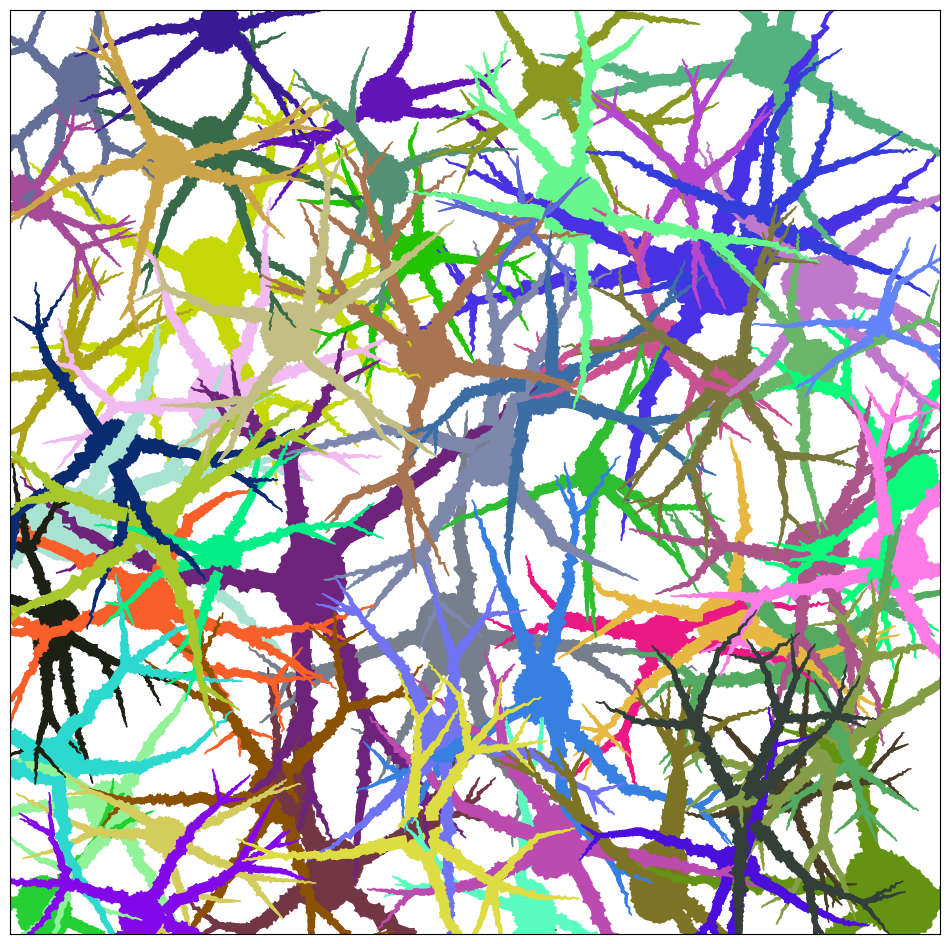

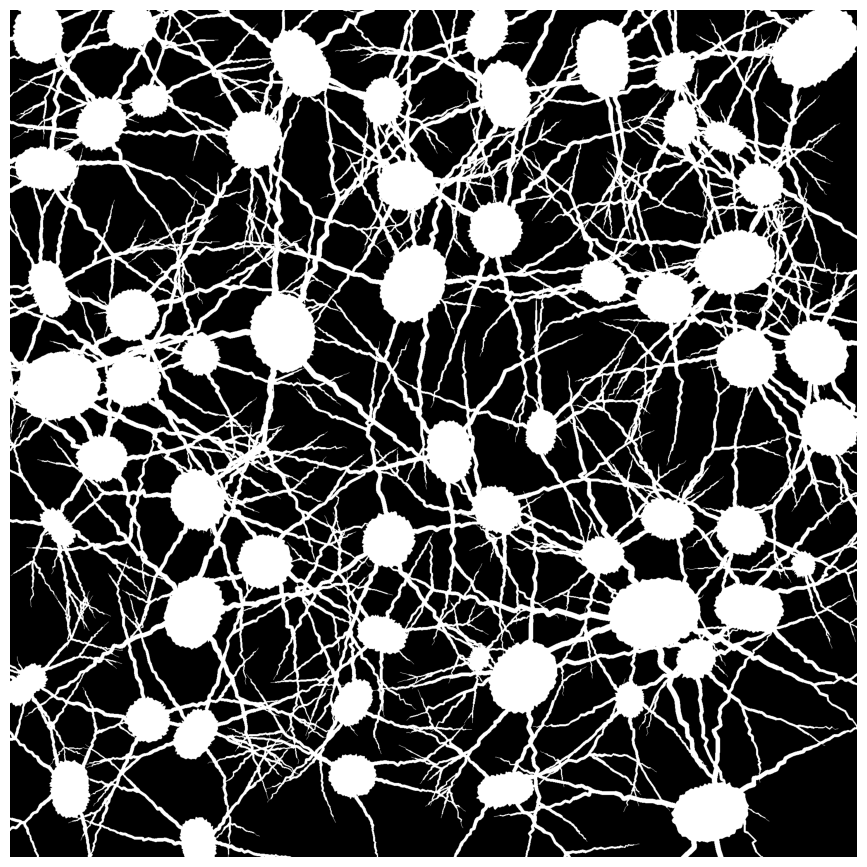

                                    nn0_network_mask  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                        nn0_neuron_1  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                        nn0_neuron_2  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                        nn0_neuron_3  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                        nn0_neuron_4  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                        nn0_neuron_5  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                        nn0_neuron_6  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                        nn0_neuron_7  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                        nn0_neuron_8  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [12]:
import os
import pickle

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile as tiff


class Soma:
    """
    Represents the soma (cell body) of a neuron.

    Attributes:
        position (tuple): The (x, y) position of the soma.
        radius (float): The radius of the soma.
        x_soma (ndarray): X-coordinates of the soma boundary.
        y_soma (ndarray): Y-coordinates of the soma boundary.
    """

    def __init__(self, position, mean_radius, std_radius):
        self.position = position
        self.radius = max(np.random.normal(mean_radius, std_radius), 0)
        self.x_soma, self.y_soma = self._generate_soma()

    def _generate_soma(self):
        """
        Generates the coordinates of the soma boundary using a parametric equation.

        Returns:
            tuple: Arrays of x and y coordinates.
        """
        theta = np.linspace(0, 2 * np.pi, 100)
        sine_variation = np.random.uniform(0, 15) * np.sin(2 * theta)
        gaussian_variation = np.random.normal(0, 2, len(theta))
        ellipse_ratio = np.random.uniform(0.8, 1.2)
        elongation_angle = np.random.uniform(0, 2 * np.pi)

        x_soma = (self.radius + gaussian_variation + sine_variation) * (
            np.cos(theta) * np.cos(elongation_angle)
            - np.sin(theta) * np.sin(elongation_angle) * ellipse_ratio
        ) + self.position[0]
        y_soma = (self.radius + gaussian_variation + sine_variation) * (
            np.sin(theta) * np.cos(elongation_angle)
            + np.cos(theta) * np.sin(elongation_angle) * ellipse_ratio
        ) + self.position[1]

        return x_soma, y_soma

    def draw(self, color):
        """
        Draws the soma using matplotlib.

        Args:
            color: Color used to fill the soma.
        """
        plt.fill(self.x_soma, self.y_soma, color=color)

    def create_binary_mask(self, size=(2048, 2048)):
        """
        Creates a binary mask of the soma.

        Args:
            size (tuple): The size of the mask.

        Returns:
            ndarray: A binary mask of the soma.
        """
        mask = np.zeros(size, dtype=np.uint8)
        coordinates = np.array([self.x_soma, self.y_soma]).T.astype(np.int32)
        cv2.fillPoly(mask, [coordinates], 1)
        return mask


class Dendrite:
    """
    Represents the dendritic tree of a neuron.

    Attributes:
        soma (Soma): The soma associated with this dendrite.
        depth (int): The maximum branching depth.
        D (float): Fractal dimension.
        branch_angle (float): Angle between branches.
        mean_branches (float): Mean number of branches.
        weave_type (str): Type of randomization in branch lengths and angles ('Gauss' or 'Uniform').
        randomness (float): Magnitude of randomness in branch lengths and angles.
        curviness (str): Type of intra-branch weaving ('Gauss' or 'Uniform').
        curviness_magnitude (float): Magnitude of intra-branch curviness.
        n_primary_dendrites (int): Number of primary dendrites starting from the soma.
        dendrite_list (list): List of branches.
        total_length (float): Total length of dendrite.
        initial_thickness (float): Initial thickness of dendrite.
        branch_lengths (ndarray): Lengths of branches at each depth.
    """

    def __init__(
        self,
        soma,
        depth,
        D,
        branch_angle,
        mean_branches,
        weave_type=None,
        randomness=0.0,
        curviness=None,
        curviness_magnitude=1.0,
        n_primary_dendrites=4,
    ):
        self.soma = soma
        self.depth = depth
        self.D = D
        self.branch_angle = branch_angle
        self.mean_branches = mean_branches
        self.weave_type = weave_type
        self.randomness = randomness
        self.curviness = curviness
        self.curviness_magnitude = curviness_magnitude
        self.n_primary_dendrites = n_primary_dendrites
        self.dendrite_list = []

        self.total_length = self._scale_total_length()
        self.initial_thickness = self._scale_initial_thickness()
        self.branch_lengths = self._generate_branch_lengths()

    def _scale_total_length(self):
        """
        Scales the total length of the dendrite based on the soma radius.

        Returns:
            float: Total length of the dendrite.
        """
        base_length = 40
        length_variation_factor = 5
        total_length = base_length + (self.soma.radius * length_variation_factor) * np.random.uniform(
            0.8, 1.2
        )
        return max(total_length, 0)

    def _generate_branch_lengths(self):
        """
        Generates branch lengths for each depth based on the fractal dimension.

        Returns:
            ndarray: Array of branch lengths for each depth.
        """
        r = self.mean_branches ** (-1 / self.D)
        branch_lengths = np.zeros(self.depth)
        normalization_factor = self.total_length / sum(r ** i for i in range(self.depth))

        for i in range(self.depth):
            branch_lengths[i] = normalization_factor * r ** i

        return branch_lengths

    def _generate_dendrite_start_points(self):
        """
        Generates starting points on the soma boundary for primary dendrites.

        Returns:
            list: List of (x, y) tuples representing start points.
        """
        start_points = []
        num_soma_points = len(self.soma.x_soma)
        base_indices = np.linspace(0, num_soma_points - 1, self.n_primary_dendrites, endpoint=False).astype(
            int
        )

        random_offsets = np.random.randint(
            -num_soma_points // (100 // self.n_primary_dendrites // 1.5),
            (100 // self.n_primary_dendrites // 1.5) + 1,
            size=self.n_primary_dendrites,
        )
        random_indices = (base_indices + random_offsets) % num_soma_points

        for index in random_indices:
            start_points.append((self.soma.x_soma[index], self.soma.y_soma[index]))

        return start_points

    def _scale_initial_thickness(self):
        """
        Scales the initial thickness of the dendrite based on soma radius and total length.

        Returns:
            float: Initial thickness of the dendrite.
        """
        base_thickness = 1
        thickness_factor = 0.02
        initial_thickness = base_thickness + thickness_factor * (self.soma.radius + self.total_length)
        return max(initial_thickness, 1)

    def _calculate_thickness(self, distance_from_start, segment_length):
        """
        Calculates the thickness at the start and end of a dendrite segment.

        Args:
            distance_from_start (float): Cumulative length from the soma to the start of the segment.
            segment_length (float): Length of the current segment.

        Returns:
            tuple: Thickness at the start and end of the segment.
        """
        proportion_start = 1 - (distance_from_start / self.total_length)
        proportion_end = 1 - ((distance_from_start + segment_length) / self.total_length)

        proportion_start = np.clip(proportion_start, 0, 1)
        proportion_end = np.clip(proportion_end, 0, 1)

        thickness_at_start = self.initial_thickness * (proportion_start) ** (1 / self.D)
        thickness_at_end = self.initial_thickness * (proportion_end) ** (1 / self.D)

        thickness_at_start = max(thickness_at_start, 1)
        thickness_at_end = max(thickness_at_end, 1)

        return thickness_at_start, thickness_at_end

    def intra_branch_weave(self, x1, y1, x2, y2, length):
        """
        Generates intra-branch weaving for curviness.

        Args:
            x1, y1 (float): Start coordinates.
            x2, y2 (float): End coordinates.
            length (float): Length of the branch.

        Returns:
            tuple: Arrays of x and y coordinates with curviness applied.
        """
        num_points = int(self.curviness_magnitude * 10)
        xs = np.linspace(x1, x2, num_points)
        ys = np.linspace(y1, y2, num_points)

        if self.curviness == 'Gauss':
            perturb_xs = xs + (length // 50) * np.random.normal(0, 1, num_points)
            perturb_ys = ys + (length // 50) * np.random.normal(0, 1, num_points)
        elif self.curviness == 'Uniform':
            perturb_xs = xs + (length // 50) * np.random.uniform(-1, 1, num_points)
            perturb_ys = ys + (length // 50) * np.random.uniform(-1, 1, num_points)
        else:
            perturb_xs = xs
            perturb_ys = ys

        perturb_xs[0], perturb_ys[0] = x1, y1
        perturb_xs[-1], perturb_ys[-1] = x2, y2

        return perturb_xs, perturb_ys

    def _grow_branch(self, x, y, angle, remaining_depth):
        """
        Recursively grows a dendritic branch.

        Args:
            x, y (float): Starting coordinates.
            angle (float): Direction of growth.
            remaining_depth (int): Remaining depth to grow.

        Returns:
            tuple: Branch data and list of new branches to grow.
        """
        if remaining_depth == 0:
            return None, []

        branch_length = self.branch_lengths[self.depth - remaining_depth]
        sum_length = sum(self.branch_lengths[: self.depth - remaining_depth])

        thickness_start, thickness_end = self._calculate_thickness(sum_length, branch_length)

        if self.weave_type == 'Gauss':
            branch_length *= 1 + np.random.normal(0, self.randomness)
            angle += np.random.normal(0, self.randomness)
        elif self.weave_type == 'Uniform':
            branch_length *= 1 + np.random.uniform(-self.randomness, self.randomness)
            angle += np.random.uniform(-self.randomness, self.randomness)

        end_x = x + branch_length * np.cos(angle)
        end_y = y + branch_length * np.sin(angle)

        weave_x, weave_y = self.intra_branch_weave(x, y, end_x, end_y, branch_length)

        branch_data = {
            'points': np.array([weave_x, weave_y]),
            'length': branch_length,
            'depth': self.depth - remaining_depth,
            'thickness_start': thickness_start,
            'thickness_end': thickness_end,
        }

        num_branches = int(np.clip(np.round(np.random.normal(self.mean_branches, 1)), 1, None))
        new_branches = []

        for i in range(num_branches):
            new_angle = angle + self.branch_angle * (i - (num_branches - 1) / 2)
            if self.weave_type == 'Gauss':
                new_angle += np.random.normal(0, self.randomness)
            elif self.weave_type == 'Uniform':
                new_angle += np.random.uniform(-self.randomness, self.randomness)

            new_branches.append(((end_x, end_y), new_angle))

        return branch_data, new_branches

    def draw(self, color):
        """
        Draws the dendritic branches using matplotlib.

        Args:
            color: Color used to draw the dendrites.
        """
        for branch in self.dendrite_list:
            points = branch['points']
            thickness_start = branch['thickness_start']
            thickness_end = branch['thickness_end']
            thicknesses = np.linspace(thickness_start, thickness_end, len(points[0]))

            for i in range(len(points[0]) - 1):
                plt.plot(points[0][i : i + 2], points[1][i : i + 2], color=color, linewidth=thicknesses[i])

    def create_dendrite_mask(self, size=(2048, 2048)):
        """
        Creates a binary mask of the dendritic branches.

        Args:
            size (tuple): The size of the mask.

        Returns:
            ndarray: A binary mask of the dendrites.
        """
        mask = np.zeros(size, dtype=np.uint8)

        for branch in self.dendrite_list:
            points = branch['points']
            thickness_start = branch['thickness_start']
            thickness_end = branch['thickness_end']
            thicknesses = np.linspace(thickness_start, thickness_end, len(points[0]))
            thicknesses = np.clip(np.round(thicknesses), 1, None).astype(int)
            coordinates = np.column_stack((points[0], points[1])).astype(np.int32)
            for i in range(len(coordinates) - 1):
                cv2.line(
                    mask,
                    tuple(coordinates[i]),
                    tuple(coordinates[i + 1]),
                    1,
                    thickness=thicknesses[i],
                )

        return mask


class Neuron:
    """
    Represents a neuron, consisting of a soma and dendrites.

    Attributes:
        position (tuple): The (x, y) position of the neuron.
        soma (Soma): The soma of the neuron.
        dendrite (Dendrite): The dendritic tree of the neuron.
        neuron_mask (ndarray): Binary mask of the neuron.
        neuron_id (str): Unique identifier of the neuron.
        current_depth (int): Current depth of dendrite growth.
        branch_ends (list): List of current branch ends for further growth.
        is_growing (bool): Indicates whether the neuron is still growing.
    """

    def __init__(
        self,
        position,
        depth,
        mean_soma_radius,
        std_soma_radius,
        D,
        branch_angle,
        mean_branches,
        weave_type=None,
        randomness=0.0,
        curviness=None,
        curviness_magnitude=1.0,
        n_primary_dendrites=4,
        network=None,
        neuron_id=None,
    ):
        self.network = network
        self.position = position
        self.soma = Soma(position, mean_soma_radius, std_soma_radius)
        self.soma_mask = self.soma.create_binary_mask(size=(network.height, network.width))
        self.dendrite = Dendrite(
            self.soma,
            depth,
            D,
            branch_angle,
            mean_branches,
            weave_type,
            randomness,
            curviness,
            curviness_magnitude,
            n_primary_dendrites,
        )
        self.dendrite_mask = np.zeros((network.height, network.width), dtype=np.uint8)
        self.neuron_mask = None
        self.neuron_id = neuron_id
        self.current_depth = 0
        self.branch_ends = []
        self.is_growing = True  # Flag to indicate if the neuron is still growing

    def generate_start_points(self):
        """
        Generates the starting points for the primary dendrites and initializes branch ends.
        """
        start_points = self.dendrite._generate_dendrite_start_points()
        self.branch_ends = [
            (point, np.arctan2(point[1] - self.position[1], point[0] - self.position[0]))
            for point in start_points
        ]

    def prepare_next_layer(self):
        """
        Prepare the proposed branches for the next layer without updating the dendrite mask.

        Returns:
            list: Proposed branches for the next layer.
        """
        if self.current_depth >= self.dendrite.depth or not self.branch_ends:
            self.is_growing = False
            return []

        proposed_branches = []

        for start_point, angle in self.branch_ends:
            branch_data, new_branches = self.dendrite._grow_branch(
                start_point[0], start_point[1], angle, self.dendrite.depth - self.current_depth
            )

            if branch_data is not None:
                proposed_branches.append(
                    {
                        'branch_data': branch_data,
                        'start_point': start_point,
                        'new_branches': new_branches,  # Include new branch ends
                    }
                )

        return proposed_branches

    def add_branches(self, accepted_branches):
        """
        Add the accepted branches to the dendrite list, update the dendrite mask, and update branch ends.

        Args:
            accepted_branches (list): List of branches to add.
        """
        new_branch_ends = []

        for branch_info in accepted_branches:
            branch_data = branch_info['branch_data']
            points = branch_data['points']
            new_branches = branch_info['new_branches']

            # Update dendrite list
            self.dendrite.dendrite_list.append(branch_data)

            # Update dendrite mask
            coordinates = np.column_stack((points[0], points[1])).astype(np.int32)
            thickness_start = branch_data['thickness_start']
            thickness_end = branch_data['thickness_end']
            thicknesses = np.linspace(thickness_start, thickness_end, len(coordinates))
            thicknesses = np.clip(np.round(thicknesses), 1, None).astype(int)
            for i in range(len(coordinates) - 1):
                cv2.line(
                    self.dendrite_mask,
                    tuple(coordinates[i]),
                    tuple(coordinates[i + 1]),
                    1,
                    thickness=thicknesses[i],
                )

            # Update branch ends with new branches from accepted branches
            new_branch_ends.extend(new_branches)

        # Update self.branch_ends for the next layer
        self.branch_ends = new_branch_ends

    def draw(self, color):
        """
        Draws the neuron by drawing its soma and dendrites.

        Args:
            color: Color used to draw the neuron.
        """
        self.soma.draw(color)
        self.dendrite.draw(color)

    def generate_binary_mask(self):
        """
        Generates a binary mask of the neuron by combining soma and dendrite masks.

        Returns:
            ndarray: Binary mask of the neuron.
        """
        self.neuron_mask = np.logical_or(self.soma_mask, self.dendrite_mask).astype(np.uint8)
        return self.neuron_mask


class Network:
    """
    Represents a network of neurons.

    Attributes:
        width (int): Width of the network.
        height (int): Height of the network.
        num_neurons (int): Number of neurons in the network.
        neuron_params (dict): Parameters for neuron creation.
        neurons (list): List of neurons in the network.
        network_mask (ndarray): Binary mask of the entire network.
        somas_mask (ndarray): Binary mask of all somas.
        network_dendrites_mask (ndarray): Binary mask of all dendrites.
        network_id (str): Unique identifier for the network.
    """

    def __init__(self, width, height, num_neurons, neuron_params, network_id):
        self.width = width
        self.height = height
        self.num_neurons = num_neurons
        self.neuron_params = neuron_params
        self.neurons = []
        self.network_mask = np.zeros((self.height, self.width), dtype=np.uint8)
        self.somas_mask = np.zeros((self.height, self.width), dtype=np.uint8)
        self.network_dendrites_mask = np.zeros((self.height, self.width), dtype=np.uint8)
        self.network_id = network_id

    def _seed_neurons(self):
        """
        Seeds neurons in the network, ensuring that no two somas overlap.
        """
        for neuron_index in range(self.num_neurons):
            max_attempts = 100  # Limit the number of attempts to avoid infinite loops
            attempts = 0

            while attempts < max_attempts:
                # Generate a random position for the neuron
                position = (np.random.uniform(0, self.width), np.random.uniform(0, self.height))
                neuron_id = f"{self.network_id}_neuron_{neuron_index + 1}"

                # Create a new neuron object
                neuron = Neuron(position, **self.neuron_params, network=self, neuron_id=neuron_id)

                # Create a binary mask of the soma
                new_soma_mask = neuron.soma.create_binary_mask(size=(self.height, self.width))

                # Check if there is an overlap with any existing somas
                overlap = np.any(np.logical_and(self.somas_mask, new_soma_mask))

                if not overlap:
                    # If there is no overlap, add the neuron to the network
                    self.neurons.append(neuron)
                    self.somas_mask = np.logical_or(self.somas_mask, new_soma_mask).astype(np.uint8)
                    neuron.generate_start_points()
                    break  # Exit the while loop and move to the next neuron

                attempts += 1

            if attempts == max_attempts:
                print(
                    f"Warning: Could not place neuron {neuron_index + 1} without overlap after {max_attempts} attempts."
                )

    def grow_network(self):
        """
        Grows the dendrites of all neurons in the network layer by layer.
        """
        growing = True
        while growing:
            growing = False
            # Collect proposed branches from all neurons
            for neuron in self.neurons:
                if neuron.is_growing:
                    proposed_branches = neuron.prepare_next_layer()
                    if proposed_branches:
                        # Directly add branches without collision checks
                        neuron.add_branches(proposed_branches)
                        growing = True
                    else:
                        neuron.is_growing = False

            # Update the network dendrite mask with all branches
            self.network_dendrites_mask = np.zeros((self.height, self.width), dtype=np.uint8)
            for neuron in self.neurons:
                self.network_dendrites_mask = np.logical_or(
                    self.network_dendrites_mask, neuron.dendrite_mask
                ).astype(np.uint8)

            # Increment the current depth for all neurons
            for neuron in self.neurons:
                if neuron.is_growing:
                    neuron.current_depth += 1

    def generate_binary_mask(self):
        """
        Generates a binary mask of the entire network by combining neuron masks.

        Returns:
            ndarray: Binary mask of the network.
        """
        self.network_mask = np.zeros((self.height, self.width), dtype=np.uint8)
        for neuron in self.neurons:
            neuron_mask = neuron.generate_binary_mask()
            self.network_mask = np.logical_or(self.network_mask, neuron_mask).astype(np.uint8)
        return self.network_mask

    def draw(self):
        """
        Draws the network of neurons using matplotlib.
        """
        plt.figure(figsize=(12, 12))
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])

        for neuron in self.neurons:
            color = np.random.rand(3)
            neuron.draw(color=color)

        plt.axis('equal')
        plt.xlim(0, self.width)
        plt.ylim(0, self.height)
        plt.show()

    def create_dataframe(self):
        """
        Creates a pandas DataFrame containing masks for the network and individual neurons.

        Returns:
            DataFrame: DataFrame with network and neuron masks.
        """
        data = {f'{self.network_id}_network_mask': [self.network_mask]}
        for neuron in self.neurons:
            data[neuron.neuron_id] = [neuron.neuron_mask]

        df = pd.DataFrame.from_dict(data, orient='columns')
        return df


def save_masks(network, output_dir='output'):
    """
    Saves the masks of individual neurons and the combined network mask to TIFF files.

    Args:
        network (Network): The network whose masks are to be saved.
        output_dir (str): Directory to save the mask files.
    """
    os.makedirs(output_dir, exist_ok=True)
    combined_mask = np.zeros((network.height, network.width), dtype=np.uint16)

    for idx, neuron in enumerate(network.neurons, start=1):
        neuron_mask = neuron.generate_binary_mask()
        # Save individual neuron mask as TIFF
        filename = f"{network.network_id}_neuron_{idx}_mask.tiff"
        filepath = os.path.join(output_dir, filename)
        tiff.imwrite(filepath, neuron_mask.astype(np.uint8), compression='deflate')

        # Add to combined mask with unique labels
        combined_mask[neuron_mask > 0] = idx

    # Save the combined mask as TIFF
    combined_mask_filename = f"{network.network_id}_combined_mask.tiff"
    combined_mask_path = os.path.join(output_dir, combined_mask_filename)
    tiff.imwrite(combined_mask_path, combined_mask.astype(np.uint16), compression='deflate')

    # Save the network image as TIFF
    network_image_filename = f"{network.network_id}_image.tiff"
    network_image_path = os.path.join(output_dir, network_image_filename)
    tiff.imwrite(network_image_path, network.network_mask.astype(np.uint8), compression='deflate')


def save_dataframe(network, df, output_dir='output'):
    """
    Saves the pandas DataFrame containing the masks to a pickle file.

    Args:
        network (Network): The network corresponding to the DataFrame.
        df (DataFrame): The DataFrame to be saved.
        output_dir (str): Directory to save the DataFrame file.
    """
    os.makedirs(output_dir, exist_ok=True)
    dataframe_filename = f"{network.network_id}_masks_dataframe.pkl"
    dataframe_path = os.path.join(output_dir, dataframe_filename)

    # Save the DataFrame using pickle
    with open(dataframe_path, 'wb') as f:
        pickle.dump(df, f)


def main():
    # Parameters
    network_width = 2048
    network_height = 2048
    num_neurons = 60

    # Neuron-specific parameters with Gaussian distribution
    neuron_params = {
        'depth': 3,
        'mean_soma_radius': 60,
        'std_soma_radius': 15,
        'D': 1.5,
        'branch_angle': np.pi / 4,
        'mean_branches': 1.5,
        'weave_type': 'Gauss',
        'randomness': 0.2,
        'curviness': 'Gauss',
        'curviness_magnitude': 1.5,
        'n_primary_dendrites': 5,
    }

    # Create and generate the network
    network = Network(network_width, network_height, num_neurons, neuron_params, 'nn0')
    network._seed_neurons()
    network.grow_network()

    # Draw the network
    network.draw()

    # Generate and display the binary mask
    network_mask = network.generate_binary_mask()
    plt.figure(figsize=(11, 11))
    plt.imshow(network_mask, cmap='gray')
    plt.axis('off')
    plt.show()

    # Create DataFrame
    nn0_df = network.create_dataframe()
    print(nn0_df)

    # Save masks and DataFrame (uncomment to save)
    #save_masks(network, output_dir='output')
    #save_dataframe(network, nn0_df, output_dir='output')


if __name__ == "__main__":
    main()
